
# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [34]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [35]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import libraries and setup matplotlib

In [120]:
import matplotlib.pylab as plt

# # Download tokenizer if not present
# import nltk
# nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import cleaned_text_to_sequence, intersperse, _clean_text, sequence_to_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
from hifigandenoiser import Denoiser
%matplotlib inline



In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
%ls checkpoints/ESpeakPhonemizer

checkpoint_0.ckpt     checkpoint_2500.ckpt  checkpoint_4500.ckpt
checkpoint_1000.ckpt  checkpoint_3000.ckpt  checkpoint_500.ckpt
checkpoint_1500.ckpt  checkpoint_3500.ckpt
checkpoint_2000.ckpt  checkpoint_4000.ckpt


In [42]:
checkpoint_path = "checkpoints/ESpeakPhonemizer/checkpoint_1000.ckpt"

## Plotting code

In [43]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [44]:
hparams = create_hparams()

## Load model from checkpoint

In [45]:
# # x = torch.load(checkpoint_path, map_location="cuda")
# x['hyper_parameters']['encoder_type'] = "transformer"
# # x['hyper_parameters']['encoder_params'] = {
# #             "conv": {"kernel_size": 5, "n_convolutions": 3, "hidden_channels": 512, "state_per_phone": 2},
# #             "transformer": {
# #                 "hidden_channels": 384,
# #                 "n_layer": 6,
# #                 "n_head": 1,
# #                 "d_head": 64,
# #                 "d_inner": 1024,
# #                 "kernel_size": 3,
# #                 "dropout": 0.1,
# #                 "dropatt": 0.1,
# #                 "dropemb": 0.0,
# #                 "embed_input": False,
# #                 "pre_lnorm": True,
# #                 "rel_attention": True,
# #             },
# #         }
# torch.save(x, checkpoint_path)

In [206]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

RuntimeError: Error(s) in loading state_dict for TrainingModule:
	size mismatch for model.encoder.encoder.encoder.layers.0.dec_attn.attn.rel_pos_emb.weight: copying a param with shape torch.Size([9, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).
	size mismatch for model.encoder.encoder.encoder.layers.1.dec_attn.attn.rel_pos_emb.weight: copying a param with shape torch.Size([9, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).
	size mismatch for model.encoder.encoder.encoder.layers.2.dec_attn.attn.rel_pos_emb.weight: copying a param with shape torch.Size([9, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).
	size mismatch for model.encoder.encoder.encoder.layers.3.dec_attn.attn.rel_pos_emb.weight: copying a param with shape torch.Size([9, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).
	size mismatch for model.encoder.encoder.encoder.layers.4.dec_attn.attn.rel_pos_emb.weight: copying a param with shape torch.Size([9, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).
	size mismatch for model.encoder.encoder.encoder.layers.5.dec_attn.attn.rel_pos_emb.weight: copying a param with shape torch.Size([9, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

## Load Hifi-gan for mel2audio synthesis and denoiser

In [197]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [198]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'g_02500000'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [199]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval().half()
generator.remove_weight_norm()

denoiser = Denoiser(generator, mode='zeros')

g_02500000
Loading 'g_02500000'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [200]:
model.model.hmm.hparams.max_sampling_time = 10000
model.model.hmm.hparams.duration_quantile_threshold=0.45
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=False
model.model.hmm.hparams.prenet_dropout_while_eval=False

## Set texts

In [201]:
texts = [
    "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS."
]

In [202]:
test_sentences = {
    1: "; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW.",
    2: "THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON.",
    3: "WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW.",
    4: "IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND.",
    5: "THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS.",
    6: "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS.",
    7: "IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS.",
    8: "IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS.",
    9: "IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING.",
    10: "DISTILLING INTELLIGENCE INTO AN ALGORITHMIC CONSTRUCT AND COMPARING IT TO THE HUMAN BRAIN MIGHT YIELD INSIGHTS.",
    11: "THE VAULT THAT WAS SEARCHED HAD IN FACT BEEN EMPTIED EARLIER THAT SAME DAY.",
    12: "ANT LIVES NEXT TO GRASSHOPPER, ANT SAYS, I LIKE TO WORK EVERY DAY.",
    13: "YOUR MEANS OF TRANSPORT FULFIL ECONOMIC REQUIREMENTS IN YOUR CHOSEN COUNTRY.",
    14: "SLEEP STILL FOGGED MY MIND AND ATTEMPTED TO FIGHT BACK THE PANIC.",
    15: "SUDDENLY, I SAW TWO FAST AND FURIOUS ; FEET DRIBBLING THE ; BALL TOWARDS MY GOAL.",
}

texts = [" ".join(test_sentences.values())]

In [203]:
# texts = [
#     "We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics, WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS."
# ]

In [204]:
def get_text(i, text):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = _clean_text(text, hparams.text_cleaners)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = cleaned_text_to_sequence(text)    
    if hparams.add_blank:
        sequence = intersperse(sequence, 0)
    sequence = torch.LongTensor(sequence).to(device)
    print(''.join(['='] * 100))
    return sequence

In [205]:
sequences = []

for i, text in enumerate(texts):
    sequence = get_text(i, text)
    sequences.append(sequence)


********************
1 - Input text: 
********************
; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON. WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW. IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND. THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS. THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS. IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS. IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIE

In [188]:
sequence_to_text(sequence.tolist())

'_;_ _w_ˌ_ɛ_n_ _ð_ə_ _s_ˈ_ʌ_n_l_a_ɪ_t_ _s_t_ɹ_ˈ_a_ɪ_k_s_ _ɹ_ˈ_e_ɪ_n_d_ɹ_ɑ_ː_p_s_ _ɪ_n_ð_ɪ_ _ˈ_ɛ_ɹ_ _;_ _ð_e_ɪ_ _ˈ_æ_k_t_ _æ_z_ _ɐ_ _p_ɹ_ˈ_ɪ_z_ə_m_ _æ_n_d_ _f_ˈ_ɔ_ː_ɹ_m_ _ɐ_ _ɹ_ˈ_e_ɪ_n_b_o_ʊ_._ _ð_i_ː_z_ _t_ˈ_e_ɪ_k_ _ð_ə_ _ʃ_ˈ_e_ɪ_p_ _;_ _ə_v_ə_ _l_ˈ_ɔ_ŋ_ _ɹ_ˈ_a_ʊ_n_d_ _ˈ_ɑ_ː_ɹ_t_ʃ_,_ _w_ɪ_ð_ _ɪ_t_s_ _p_ˈ_æ_θ_ _h_ˈ_a_ɪ_ _ə_b_ˈ_ʌ_v_,_ _æ_n_d_ _ɪ_t_s_ _t_ˈ_u_ː_ _ˈ_ɛ_n_d_z_ _ɐ_p_ˈ_æ_ɹ_ə_n_t_l_i_ _b_ᵻ_j_ˌ_ɔ_n_d_ _ð_ə_ _h_ɚ_ɹ_ˈ_a_ɪ_z_ə_n_._ _w_ˌ_ɛ_n_ _ɐ_ _m_ˈ_æ_n_ _l_ˈ_ʊ_k_s_ _f_ɔ_ː_ɹ_ _s_ˈ_ʌ_m_θ_ɪ_ŋ_ _b_ᵻ_j_ˌ_ɔ_n_d_ _h_ɪ_z_ _ɹ_ˈ_i_ː_t_ʃ_,_ _h_ɪ_z_ _f_ɹ_ˈ_ɛ_n_d_z_ _s_ˈ_e_ɪ_ _h_i_ː_ _ɪ_z_ _l_ˈ_ʊ_k_ɪ_ŋ_ _f_ɚ_ð_ə_ _p_ˈ_ɑ_ː_t_ _ʌ_v_ _ɡ_ˈ_o_ʊ_l_d_ _æ_t_ _ð_ɪ_ _ˈ_ɛ_n_d_ _ʌ_v_ð_ə_ _ɹ_ˈ_e_ɪ_n_b_o_ʊ_._ _ɪ_f_ _ð_ə_ _ɹ_ˈ_ɛ_d_ _ʌ_v_ð_ə_ _s_ˈ_ɛ_k_ə_n_d_ _b_ˈ_o_ʊ_ _f_ˈ_ɔ_ː_l_z_ _ə_p_ˌ_ɑ_ː_n_ _ð_ə_ _ɡ_ɹ_ˈ_i_ː_n_ _ʌ_v_ð_ə_ _f_ˈ_ɜ_ː_s_t_,_ _ð_ə_ _ɹ_ɪ_z_ˈ_ʌ_l_t_ _ɪ_z_ _t_ə_ _ɡ_ˈ_ɪ_v_ _ɐ_ _b_ˈ_o_ʊ_ _w_ɪ_ð_ _ɐ_n_ _ɐ_b_n_ˈ_o_ː_ɹ_m_ə_l_i_ _w_ˈ_a_ɪ_d_ _j_ˈ_ɛ_l_o_ʊ_ _b_ˈ_æ_n_d_._ _ð_ɪ_ _ˈ_æ_k_t_ʃ_u_ː_ə_l_ _p_ɹ_ˈ_a_

## Decode text input and plot results

In [193]:
t = 0.667

In [194]:
from tqdm.auto import tqdm
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all = [], []
    for sequence in tqdm(sequences, leave=False):
        mel_output, hidden_state_travelled, _, _ = model.sample(sequence.squeeze(0), sampling_temp=t)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)
        

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualisations of the output

0 ; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON. WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW. IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND. THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS. THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS. IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS. IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING. DISTILLING INTELLIGENCE INTO AN ALGORI

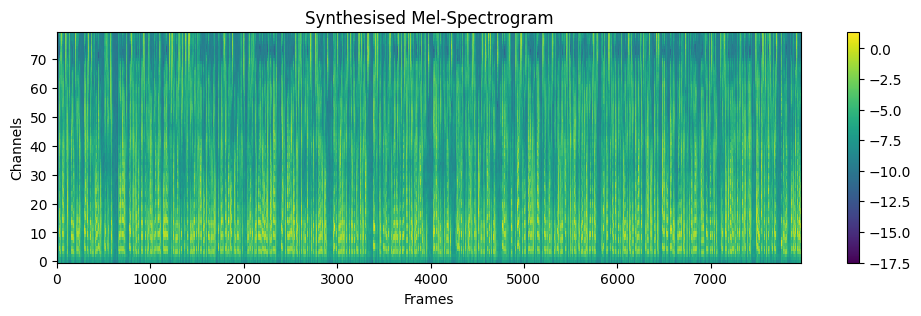

In [195]:
for i, mel_output in enumerate(mel_outputs):
    print(i, texts[i])
    plot_spectrogram_to_numpy(np.array(mel_output.float().cpu()).T)

### Synthesize audio from spectrogram using HiFiGAN

### Interesting denoising

In [196]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = mel_output.transpose(1, 2)
        audio = generator(mel_output)
        audio = denoiser(audio[:, 0], strength=0.004)[:, 0]
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: ; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON. WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW. IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND. THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS. THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS. IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS. IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING. DISTILLI

***********************************



### Save to wav files using soundfile

In [ ]:
import soundfile as sf
from pathlib import Path

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
        filename = basepath / f'OverFlow_{i + 1}.wav'
        sr = 22500
        sf.write(filename, audio.data.squeeze().cpu().numpy(), 
                 22500, 'PCM_24')
        print(f'Successfully written: {filename}')
